In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import xarray

DATA_DIR = "../Data/"
GOES_DIR = DATA_DIR+"GOES/"
FIIRMS_DIR = DATA_DIR+"FIIRMS/"
MOPITT_DIR = "/media/darp_lord/35E4790223F5E938/DATA/MOPITT/"
GOES17_DIR = "/media/darp_lord/35E4790223F5E938/DATA/GOES17"

In [58]:
suomi_viirs = pd.read_csv(FIIRMS_DIR+"SUOMI_VIIRS_C2_USA_contiguous_and_Hawaii_7d.csv")
usa = suomi_viirs[suomi_viirs['longitude'].between(left=-124.848974, right=24.396308) & suomi_viirs['latitude'].between(left=-66.885444, right=49.384358)]
usa = usa[usa['acq_date']=='2020-10-02']
usa

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,confidence,version,bright_ti5,frp,daynight
31241,28.56370,-82.36014,295.7,0.33,0.55,2020-10-02,636,N,nominal,2.0NRT,277.2,0.5,N
31242,28.21171,-88.74822,302.2,0.78,0.78,2020-10-02,636,N,nominal,2.0NRT,291.1,1.9,N
31243,28.21140,-88.73982,318.9,0.78,0.78,2020-10-02,636,N,nominal,2.0NRT,291.4,1.9,N
31244,28.21109,-88.74554,319.0,0.78,0.78,2020-10-02,636,N,nominal,2.0NRT,291.4,3.1,N
31245,18.92967,-70.35490,330.8,0.56,0.43,2020-10-02,636,N,nominal,2.0NRT,291.4,5.1,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35674,46.54585,-116.42999,352.2,0.61,0.54,2020-10-02,2118,N,nominal,2.0NRT,298.0,22.2,D
35675,46.55082,-116.43060,344.6,0.61,0.54,2020-10-02,2118,N,nominal,2.0NRT,297.5,22.2,D
35676,47.84986,-113.71470,328.3,0.42,0.61,2020-10-02,2118,N,nominal,2.0NRT,289.3,3.4,D
35677,47.57084,-122.36845,334.4,0.51,0.41,2020-10-02,2118,N,nominal,2.0NRT,298.5,4.1,D


In [59]:
usa['acq_time'].value_counts()

954     1720
1930     687
812      483
2112     481
2118     317
1936     245
1748     219
1754     117
818       73
630       65
948       10
636        6
806        4
1130       3
Name: acq_time, dtype: int64

In [71]:
GOES_FILES = []
for dirname, _, filenames in os.walk(GOES_DIR):
    for filename in filenames:
        split = filename.split(".")[0].split("_")
        times = split[-3:]
        band_type = split[1]
        channel = band_type.split("-")[-1]
        metric_type = band_type[:-(len(channel)+1)]
        GOES_FILES.append((
            times[0][1:],
            times[1][1:],
            times[2][1:],
            metric_type,
            channel,
            os.path.join(dirname, filename)))
GOES_FILES = pd.DataFrame(GOES_FILES, columns=["start", "end", "creation", "metric", "channel", "path"])


goes_sorted = GOES_FILES.sort_values(['start', 'channel'])
goes_sorted = goes_sorted[goes_sorted['metric']=="ABI-L1b-RadC"].reset_index(drop=True)
goes_sorted.head(10)

,start,end,creation,metric,channel,path
0,20202760001160,20202760003533,20202760003572,ABI-L1b-RadC,M6C02,../Data/GOES/00/OR_ABI-L1b-RadC-M6C02_G16_s202...
1,20202760001160,20202760003545,20202760004012,ABI-L1b-RadC,M6C07,../Data/GOES/00/OR_ABI-L1b-RadC-M6C07_G16_s202...
2,20202760001160,20202760003533,20202760004058,ABI-L1b-RadC,M6C14,../Data/GOES/00/OR_ABI-L1b-RadC-M6C14_G16_s202...
3,20202760001160,20202760003539,20202760004063,ABI-L1b-RadC,M6C15,../Data/GOES/00/OR_ABI-L1b-RadC-M6C15_G16_s202...
4,20202760006160,20202760008533,20202760008563,ABI-L1b-RadC,M6C02,../Data/GOES/00/OR_ABI-L1b-RadC-M6C02_G16_s202...
5,20202760006160,20202760008545,20202760009055,ABI-L1b-RadC,M6C07,../Data/GOES/00/OR_ABI-L1b-RadC-M6C07_G16_s202...
6,20202760006160,20202760008533,20202760009060,ABI-L1b-RadC,M6C14,../Data/GOES/00/OR_ABI-L1b-RadC-M6C14_G16_s202...
7,20202760006160,20202760008539,20202760009039,ABI-L1b-RadC,M6C15,../Data/GOES/00/OR_ABI-L1b-RadC-M6C15_G16_s202...
8,20202760011160,20202760013533,20202760013563,ABI-L1b-RadC,M6C02,../Data/GOES/00/OR_ABI-L1b-RadC-M6C02_G16_s202...
9,20202760011160,20202760013545,20202760014024,ABI-L1b-RadC,M6C07,../Data/GOES/00/OR_ABI-L1b-RadC-M6C07_G16_s202...


In [61]:
GOES_FILES = []
times = ["%.2d"%i for i in range(24)]
for dirname, _, filenames in os.walk(GOES17_DIR):
    if dirname.split("/")[-1] in times:
        for filename in filenames:
            split = filename.split(".")[0].split("_")
            times = split[-3:]
            band_type = split[1]
            channel = band_type.split("-")[-1]
            metric_type = band_type[:-(len(channel)+1)]
            GOES_FILES.append((
                times[0][1:],
                times[1][1:],
                times[2][1:],
                metric_type,
                channel,
                os.path.join(dirname, filename)))
GOES_FILES = pd.DataFrame(GOES_FILES, columns=["start", "end", "creation", "metric", "channel", "path"])


goes17_sorted = GOES_FILES.sort_values('start')
goes17_sorted = goes17_sorted[goes17_sorted['metric']=="ABI-L1b-RadC"].reset_index(drop=True)
goes17_sorted.head(10)

,start,end,creation,metric,channel,path
0,20202760001176,20202760003549,20202760003580,ABI-L1b-RadC,M6C02,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...
1,20202760001176,20202760003555,20202760004050,ABI-L1b-RadC,M6C15,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...
2,20202760001176,20202760003549,20202760004058,ABI-L1b-RadC,M6C14,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...
3,20202760001176,20202760003560,20202760004071,ABI-L1b-RadC,M6C07,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...
4,20202760006176,20202760008555,20202760009053,ABI-L1b-RadC,M6C15,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...
5,20202760006176,20202760008560,20202760009060,ABI-L1b-RadC,M6C07,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...
6,20202760006176,20202760008549,20202760009048,ABI-L1b-RadC,M6C14,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...
7,20202760006176,20202760008549,20202760008570,ABI-L1b-RadC,M6C02,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...
8,20202760011176,20202760013549,20202760013579,ABI-L1b-RadC,M6C02,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...
9,20202760011176,20202760013549,20202760014047,ABI-L1b-RadC,M6C14,/media/darp_lord/35E4790223F5E938/DATA/GOES17/...


In [62]:
goes_sorted['start'].str[:-1]

0       2020276000116
1       2020276000116
2       2020276000116
3       2020276000116
4       2020276000616
            ...      
1147    2020276235115
1148    2020276235615
1149    2020276235615
1150    2020276235615
1151    2020276235615
Name: start, Length: 1152, dtype: object

In [63]:
goes_sorted['start'] = pd.to_datetime("20201002"+goes_sorted['start'].str[7:-1], format="%Y%m%d%H%M%S")
goes_sorted['end'] = pd.to_datetime("20201002"+goes_sorted['end'].str[7:-1], format="%Y%m%d%H%M%S")
goes_sorted

,start,end,creation,metric,channel,path
0,2020-10-02 00:01:16,2020-10-02 00:03:53,20202760003572,ABI-L1b-RadC,M6C02,../Data/GOES/00/OR_ABI-L1b-RadC-M6C02_G16_s202...
1,2020-10-02 00:01:16,2020-10-02 00:03:54,20202760004012,ABI-L1b-RadC,M6C07,../Data/GOES/00/OR_ABI-L1b-RadC-M6C07_G16_s202...
2,2020-10-02 00:01:16,2020-10-02 00:03:53,20202760004058,ABI-L1b-RadC,M6C14,../Data/GOES/00/OR_ABI-L1b-RadC-M6C14_G16_s202...
3,2020-10-02 00:01:16,2020-10-02 00:03:53,20202760004063,ABI-L1b-RadC,M6C15,../Data/GOES/00/OR_ABI-L1b-RadC-M6C15_G16_s202...
4,2020-10-02 00:06:16,2020-10-02 00:08:53,20202760008563,ABI-L1b-RadC,M6C02,../Data/GOES/00/OR_ABI-L1b-RadC-M6C02_G16_s202...
...,...,...,...,...,...,...
1147,2020-10-02 23:51:15,2020-10-02 23:53:53,20202762354065,ABI-L1b-RadC,M6C14,../Data/GOES/23/OR_ABI-L1b-RadC-M6C14_G16_s202...
1148,2020-10-02 23:56:15,2020-10-02 23:58:54,20202762359010,ABI-L1b-RadC,M6C07,../Data/GOES/23/OR_ABI-L1b-RadC-M6C07_G16_s202...
1149,2020-10-02 23:56:15,2020-10-02 23:58:53,20202762359054,ABI-L1b-RadC,M6C14,../Data/GOES/23/OR_ABI-L1b-RadC-M6C14_G16_s202...
1150,2020-10-02 23:56:15,2020-10-02 23:58:53,20202762358561,ABI-L1b-RadC,M6C02,../Data/GOES/23/OR_ABI-L1b-RadC-M6C02_G16_s202...


In [64]:
usa['timestamp'] = pd.to_datetime("20201002"+usa['acq_time'].astype(str), format="%Y%m%d%H%M")
usa

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,confidence,version,bright_ti5,frp,daynight,timestamp
31241,28.56370,-82.36014,295.7,0.33,0.55,2020-10-02,636,N,nominal,2.0NRT,277.2,0.5,N,2020-10-02 06:36:00
31242,28.21171,-88.74822,302.2,0.78,0.78,2020-10-02,636,N,nominal,2.0NRT,291.1,1.9,N,2020-10-02 06:36:00
31243,28.21140,-88.73982,318.9,0.78,0.78,2020-10-02,636,N,nominal,2.0NRT,291.4,1.9,N,2020-10-02 06:36:00
31244,28.21109,-88.74554,319.0,0.78,0.78,2020-10-02,636,N,nominal,2.0NRT,291.4,3.1,N,2020-10-02 06:36:00
31245,18.92967,-70.35490,330.8,0.56,0.43,2020-10-02,636,N,nominal,2.0NRT,291.4,5.1,N,2020-10-02 06:36:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35674,46.54585,-116.42999,352.2,0.61,0.54,2020-10-02,2118,N,nominal,2.0NRT,298.0,22.2,D,2020-10-02 21:18:00
35675,46.55082,-116.43060,344.6,0.61,0.54,2020-10-02,2118,N,nominal,2.0NRT,297.5,22.2,D,2020-10-02 21:18:00
35676,47.84986,-113.71470,328.3,0.42,0.61,2020-10-02,2118,N,nominal,2.0NRT,289.3,3.4,D,2020-10-02 21:18:00
35677,47.57084,-122.36845,334.4,0.51,0.41,2020-10-02,2118,N,nominal,2.0NRT,298.5,4.1,D,2020-10-02 21:18:00


In [65]:
usa['files'] = usa['timestamp'].apply(lambda x: goes_sorted[(goes_sorted['end'] > x)]['path'].head(4).values)
usa

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,confidence,version,bright_ti5,frp,daynight,timestamp,files
31241,28.56370,-82.36014,295.7,0.33,0.55,2020-10-02,636,N,nominal,2.0NRT,277.2,0.5,N,2020-10-02 06:36:00,[../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
31242,28.21171,-88.74822,302.2,0.78,0.78,2020-10-02,636,N,nominal,2.0NRT,291.1,1.9,N,2020-10-02 06:36:00,[../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
31243,28.21140,-88.73982,318.9,0.78,0.78,2020-10-02,636,N,nominal,2.0NRT,291.4,1.9,N,2020-10-02 06:36:00,[../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
31244,28.21109,-88.74554,319.0,0.78,0.78,2020-10-02,636,N,nominal,2.0NRT,291.4,3.1,N,2020-10-02 06:36:00,[../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
31245,18.92967,-70.35490,330.8,0.56,0.43,2020-10-02,636,N,nominal,2.0NRT,291.4,5.1,N,2020-10-02 06:36:00,[../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35674,46.54585,-116.42999,352.2,0.61,0.54,2020-10-02,2118,N,nominal,2.0NRT,298.0,22.2,D,2020-10-02 21:18:00,[../Data/GOES/21/OR_ABI-L1b-RadC-M6C14_G16_s20...
35675,46.55082,-116.43060,344.6,0.61,0.54,2020-10-02,2118,N,nominal,2.0NRT,297.5,22.2,D,2020-10-02 21:18:00,[../Data/GOES/21/OR_ABI-L1b-RadC-M6C14_G16_s20...
35676,47.84986,-113.71470,328.3,0.42,0.61,2020-10-02,2118,N,nominal,2.0NRT,289.3,3.4,D,2020-10-02 21:18:00,[../Data/GOES/21/OR_ABI-L1b-RadC-M6C14_G16_s20...
35677,47.57084,-122.36845,334.4,0.51,0.41,2020-10-02,2118,N,nominal,2.0NRT,298.5,4.1,D,2020-10-02 21:18:00,[../Data/GOES/21/OR_ABI-L1b-RadC-M6C14_G16_s20...


In [2]:
data = xarray.open_dataset('../Data/GOES/00/OR_ABI-L1b-RadC-M6C02_G16_s20202760001160_e20202760003533_c20202760003572.nc')
data

<xarray.Dataset>
Dimensions:                                           (band: 1, num_star_looks: 24, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 10000, y: 6000)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.128233 .....
  * x                                                 (x) float32 -0.101353 ....
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: band, num_star_looks, number_of_image_bounds, number_of_time_bounds
Data variables:
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                    float32 ...
    nominal_satellite_subpoint_lon                    float32 ...
    nominal_satellite_height                          float32 ...
    geospatial_lat_lon_extent                         float32 ...
    yaw_flip_flag                                     float32 ...
    esun                                              float32 ...
    kappa0                                            float32 ...
    planck_fk1                                        float32 ...
    planck_fk2                                        float32 ...
    planck_bc1                                        float32 ...
    planck_bc2                                        float32 ...
    valid_pixel_count                                 float64 ...
    missing_pixel_count                               float64 ...
    saturated_pixel_count                             float64 ...
    undersaturated_pixel_count                        float64 ...
    focal_plane_temperature_threshold_exceeded_count  float64 ...
    min_radiance_value_of_valid_pixels                float32 ...
    max_radiance_value_of_valid_pixels                float32 ...
    mean_radiance_value_of_valid_pixels               float32 ...
    std_dev_radiance_value_of_valid_pixels            float32 ...
    maximum_focal_plane_temperature                   float32 ...
    focal_plane_temperature_threshold_increasing      float32 ...
    focal_plane_temperature_threshold_decreasing      float32 ...
    percent_uncorrectable_L0_errors                   float32 ...
    earth_sun_distance_anomaly_in_AU                  float32 ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    production_environment:    OE
    spatial_resolution:        0.5km at nadir
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    

In [88]:
data.sel(x=0.04, y=0.04, method='nearest')

<xarray.Dataset>
Dimensions:                                           (band: 1, num_star_looks: 24, number_of_image_bounds: 2, number_of_time_bounds: 2)
Coordinates:
    t                                                 datetime64[ns] 2020-10-...
    y                                                 float32 0.044247
    x                                                 float32 0.03863301
    y_image                                           float32 0.08624
    x_image                                           float32 -0.03136
    band_id                                           (band) int8 2
    band_wavelength                                   (band) float32 0.64
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: band, num_star_looks, number_of_image_bounds, number_of_time_bounds
Data variables:
    Rad                                               float32 ...
    DQF                                               float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 -2147483647
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                    float64 0.0
    nominal_satellite_subpoint_lon                    float64 -75.2
    nominal_satellite_height                          float64 3.579e+04
    geospatial_lat_lon_extent                         float32 9.96921e+36
    yaw_flip_flag                                     float64 0.0
    esun                                              float64 1.631e+03
    kappa0                                            float64 0.001929
    planck_fk1                                        float64 nan
    planck_fk2                                        float64 nan
    planck_bc1                                        float64 nan
    planck_bc2                                        float64 nan
    valid_pixel_count                                 float64 5.925e+07
    missing_pixel_count                               float64 8.0
    saturated_pixel_count                             float64 0.0
    undersaturated_pixel_count                        float64 0.0
    focal_plane_temperature_threshold_exceeded_count  float64 nan
    min_radiance_value_of_valid_pixels                float64 -2.306
    max_radiance_value_of_valid_pixels                float64 324.2
    mean_radiance_value_of_valid_pixels               float64 10.74
    std_dev_radiance_value_of_valid_pixels            float64 25.42
    maximum_focal_plane_temperature                   float64 nan
    focal_plane_temperature_threshold_increasing      float64 nan
    focal_plane_temperature_threshold_decreasing      float64 nan
    percent_uncorrectable_L0_errors                   float64 0.0
    earth_sun_distance_anomaly_in_AU                  float64 1.001
    algorithm_dynamic_input_data_container            int32 -2147483647
    processing_parm_version_container                 int32 -2147483647
    algorithm_product_version_container               int32 -2147483647
    star_id                                           (num_star_looks) float32 ...
    channel_integration_time                          float64 162.0
    channel_gain_field                                float64 0.0
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    production_environment:    OE
    spatial_resolution:        0.5km at nadir
    Metadata_Convention

In [3]:
proj_info = data['goes_imager_projection']
lon_origin = proj_info.longitude_of_projection_origin
H = proj_info.perspective_point_height+proj_info.semi_major_axis
r_eq = proj_info.semi_major_axis
r_pol = proj_info.semi_minor_axis

# Data info
lat_rad_1d = data['x'][:]
lon_rad_1d = data['y'][:]

# close file when finished
# data.close()
# data = None

# create meshgrid filled with radian angles
lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

# lat/lon calc routine from satellite radian angle vectors

lambda_0 = (lon_origin*np.pi)/180.0

a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
c_var = (H**2.0)-(r_eq**2.0)

r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
s_y = - r_s*np.sin(lat_rad)
s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)


# print test coordinates
print('{} N, {} W'.format(lat[318,1849],abs(lon[318,1849])))

<ipython-input-3-c667cfce6357>:26: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


50.62828826904297 N, 122.84297180175781 W


In [9]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj    
from mpl_toolkits.basemap import Basemap

In [12]:
data = Dataset('../Data/GOES/00/OR_ABI-L1b-RadC-M6C07_G16_s20202760001160_e20202760003545_c20202760004012.nc', "r")

In [4]:
sat_h = data.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = data.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = data.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = data.variables['x'][:] * sat_h
Y = data.variables['y'][:] * sat_h

In [13]:
R = data.variables['Rad'][:].data

In [10]:
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

lats[data.variables['Rad'][:].mask] = np.nan
lons[data.variables['Rad'][:].mask] = np.nan

In [19]:
pd.DataFrame(lons.data.T).describe()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
count,2135.000000,2137.000000,2138.000000,2140.000000,2141.000000,2143.000000,2145.000000,2146.000000,2148.000000,2149.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,-88.903961,-88.931416,-88.930779,-88.958124,-88.957701,-88.984989,-89.012519,-89.011961,-89.039371,-89.039036,...,-86.171106,-86.169742,-86.168380,-86.167021,-86.165664,-86.164309,-86.162956,-86.161606,-86.160257,-86.158911
std,22.499454,22.511536,22.491447,22.503345,22.483855,22.495712,22.508275,22.488502,22.500846,22.481698,...,14.425515,14.423738,14.421964,14.420193,14.418425,14.416660,14.414898,14.413139,14.411383,14.409629
min,-147.609407,-148.404960,-147.392434,-147.995517,-147.219767,-147.736831,-148.635423,-147.542708,-148.208128,-147.388814,...,-113.122575,-113.117227,-113.111889,-113.106560,-113.101241,-113.095931,-113.090629,-113.085336,-113.080053,-113.074779
25%,-105.418986,-105.446276,-105.443060,-105.470391,-105.467254,-105.494631,-105.521998,-105.518979,-105.546400,-105.543457,...,-98.194803,-98.192115,-98.189432,-98.186753,-98.184079,-98.181408,-98.178742,-98.176081,-98.173424,-98.170771
50%,-86.662951,-86.684207,-86.689594,-86.710825,-86.716210,-86.737421,-86.758606,-86.763987,-86.785151,-86.790529,...,-85.590370,-85.589239,-85.588110,-85.586983,-85.585858,-85.584734,-85.583613,-85.582493,-85.581375,-85.580258
75%,-70.234328,-70.253814,-70.265601,-70.285011,-70.296737,-70.316073,-70.335370,-70.347003,-70.366227,-70.377801,...,-73.786534,-73.786661,-73.786788,-73.786914,-73.787041,-73.787167,-73.787293,-73.787418,-73.787544,-73.787669
max,-52.946873,-52.968568,-52.990183,-53.011718,-53.033173,-53.054549,-53.075851,-53.097070,-53.118211,-53.139274,...,-61.897043,-61.898458,-61.899870,-61.901280,-61.902688,-61.904094,-61.905497,-61.906898,-61.908297,-61.909694


In [14]:
proj_info = data.variables['goes_imager_projection']
lon_origin = proj_info.longitude_of_projection_origin
H = proj_info.perspective_point_height+proj_info.semi_major_axis
r_eq = proj_info.semi_major_axis
r_pol = proj_info.semi_minor_axis

# Data info
lat_rad_1d = data.variables['x'][:]
lon_rad_1d = data.variables['y'][:]

# close file when finished
data.close()
data = None

# create meshgrid filled with radian angles
lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

# lat/lon calc routine from satellite radian angle vectors

lambda_0 = (lon_origin*np.pi)/180.0

a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
c_var = (H**2.0)-(r_eq**2.0)

r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
s_y = - r_s*np.sin(lat_rad)
s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)


# print test coordinates
print('{} N, {} W'.format(lat[318,1849],abs(lon[318,1849])))

<ipython-input-14-887404104757>:26: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
<ipython-input-14-887404104757>:32: RuntimeWarning: invalid value encountered in sqrt
  lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))


40.702117919921875 N, 74.01709747314453 W


In [45]:
print('{} N, {} W'.format(lat[601,1400],lon[601,1400]))

33.500099182128906 N, -84.19031524658203 W


In [5]:
lat[601,:]

array([      nan,       nan,       nan, ..., 46.10875 , 46.108833,
       46.10941 ], dtype=float32)

In [53]:

np.min(np.abs((lat-28.56370)))

5.722046e-06

In [56]:
lat.data

array([[57.29578  , 57.29578  , 57.29578  , ..., 51.360435 , 51.362617 ,
        51.3643   ],
       [57.29578  , 57.29578  , 57.29578  , ..., 51.322357 , 51.32386  ,
        51.326122 ],
       [57.29578  , 57.29578  , 57.29578  , ..., 51.28382  , 51.285614 ,
        51.287914 ],
       ...,
       [15.160467 , 15.159776 , 15.158972 , ..., 14.676444 , 14.6766615,
        14.676866 ],
       [15.140513 , 15.13982  , 15.139026 , ..., 14.657232 , 14.657422 ,
        14.657647 ],
       [15.120589 , 15.119889 , 15.119103 , ..., 14.638046 , 14.638264 ,
        14.638501 ]], dtype=float32)

In [57]:
lon.data

array([[   0.26179945,    0.26179945,    0.26179945, ...,  -53.017624  ,
         -52.982132  ,  -52.947044  ],
       [   0.26179945,    0.26179945,    0.26179945, ...,  -53.039074  ,
         -53.00418   ,  -52.968655  ],
       [   0.26179945,    0.26179945,    0.26179945, ...,  -53.060863  ,
         -53.025772  ,  -52.990253  ],
       ...,
       [-113.08538   , -113.05826   , -113.0308    , ...,  -61.945957  ,
         -61.92641   ,  -61.906868  ],
       [-113.080055  , -113.052925  , -113.02549   , ...,  -61.947376  ,
         -61.927856  ,  -61.908302  ],
       [-113.07482   , -113.047676  , -113.02028   , ...,  -61.94878   ,
         -61.929237  ,  -61.909668  ]], dtype=float32)

In [63]:
data.variables['Rad'][:].data.shape

(1500, 2500)

In [68]:
data.variables['Rad'][:].data

array([[1.63830000e+04, 1.63830000e+04, 1.63830000e+04, ...,
        3.06557208e-01, 3.28458130e-01, 3.40972930e-01],
       [1.63830000e+04, 1.63830000e+04, 1.63830000e+04, ...,
        2.92478055e-01, 3.11250269e-01, 3.30022484e-01],
       [1.63830000e+04, 1.63830000e+04, 1.63830000e+04, ...,
        2.89349347e-01, 2.98735470e-01, 3.12814623e-01],
       ...,
       [1.00062892e-01, 1.11013353e-01, 1.18835106e-01, ...,
        2.65383907e-02, 3.12314443e-02, 3.27957980e-02],
       [1.03191599e-01, 1.12577707e-01, 1.28221214e-01, ...,
        2.96670981e-02, 2.96670981e-02, 3.43601443e-02],
       [1.06320292e-01, 1.04755953e-01, 1.21963814e-01, ...,
        3.43601443e-02, 3.43601443e-02, 3.59244980e-02]], dtype=float32)

In [15]:
data_df = pd.DataFrame({
    'lat':lat.data.flatten(),
    'lon':lon.data.flatten(),
    'rad':R.flatten(),
})

In [65]:
data_df.head()

,lat,lon,rad
0,57.29578,0.261799,16383.0
1,57.29578,0.261799,16383.0
2,57.29578,0.261799,16383.0
3,57.29578,0.261799,16383.0
4,57.29578,0.261799,16383.0


In [53]:
data_df = data_df.drop_duplicates().reset_index(drop=True)
data_df

,lat,lon,rad
0,57.295780,0.261799,16383.000000
1,56.576508,-147.607986,0.248676
2,56.440037,-146.567276,0.237726
3,56.350067,-145.875961,0.243983
4,56.276234,-145.308609,0.253369
...,...,...,...
3702835,14.637698,-61.987778,0.024974
3702836,14.637847,-61.968307,0.032796
3702837,14.638046,-61.948780,0.034360
3702838,14.638264,-61.929237,0.034360


In [43]:
np.count_nonzero(np.isnan(Z))

3088

In [44]:
Z.shape

(100, 100)

<ipython-input-54-322c0af670db>:23: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X, Y, Z, rstride=5, cstride=5, cmap=cm.jet, vmin=np.nanmin(Z), vmax=np.nanmax(Z), shade=False)


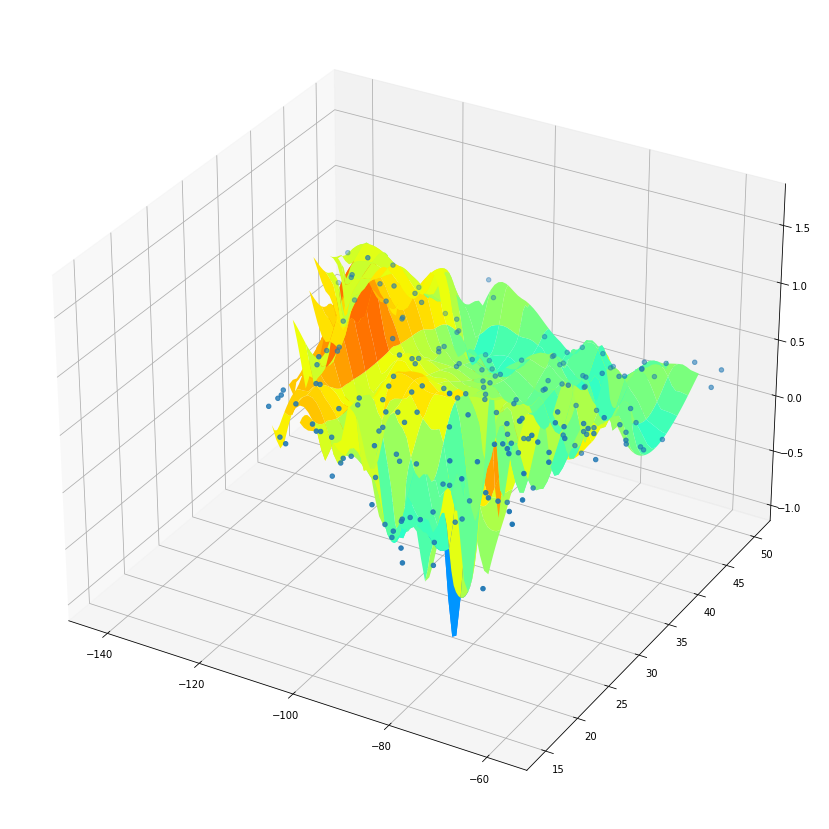

In [54]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

df = data_df.sample(200)
x = df['lon']
y = df['lat']

z = df['rad']

xi = np.linspace(min(x),max(x), 100)
yi = np.linspace(min(y),max(y), 100)

X,Y = np.meshgrid(xi,yi)

Z = griddata((x, y), z, (X, Y), method='cubic')

fig = plt.figure(figsize=(16,15))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=5, cstride=5, cmap=cm.jet, vmin=np.nanmin(Z), vmax=np.nanmax(Z), shade=False)
scat = ax.scatter(x, y, z)

In [70]:
np.dstack([Z, Z, Z]).shape


(100, 100, 3)

In [ ]:
def get_array(df):
    x = df['lon']
    y = df['lat']
    z = df['rad']
    xi = np.linspace(min(x),max(x), 100)
    yi = np.linspace(min(y),max(y), 100)

    X,Y = np.meshgrid(xi,yi)

    Z = griddata((x, y), z, (X, Y), method='cubic')
    return Z

In [55]:
from scipy.spatial import KDTree

kd = KDTree(data_df[['lat', 'lon']][:10000])

In [10]:
data_df['lon'].describe()

count    3.750000e+06
mean    -8.695986e+01
std      2.045124e+01
min     -1.520550e+02
25%     -1.018606e+02
50%     -8.670867e+01
75%     -7.288792e+01
max      2.617995e-01
Name: lon, dtype: float64

In [49]:
kd.query([50.679516, -81.980331], 200)

(array([4.50774899e-07, 3.08345247e-02, 3.09771224e-02, 3.71173668e-02,
        3.72379559e-02, 4.34923570e-02, 4.37626532e-02, 5.23052490e-02,
        5.28545514e-02, 6.16205495e-02, 6.17675002e-02, 6.58425269e-02,
        6.60261536e-02, 7.45534085e-02, 7.55094466e-02, 7.74220246e-02,
        7.77922831e-02, 8.58115605e-02, 8.78000973e-02, 9.24475829e-02,
        9.26673086e-02, 9.31215644e-02, 9.33366977e-02, 1.05015759e-01,
        1.05344419e-01, 1.06158075e-01, 1.07920668e-01, 1.10427524e-01,
        1.11616935e-01, 1.17548613e-01, 1.21596472e-01, 1.22133783e-01,
        1.22299902e-01, 1.23347377e-01, 1.23385762e-01, 1.29165268e-01,
        1.31696245e-01, 1.32150421e-01, 1.34835329e-01, 1.35480494e-01,
        1.37521851e-01, 1.50776996e-01, 1.51854727e-01, 1.52019182e-01,
        1.54134103e-01, 1.54292461e-01, 1.55547887e-01, 1.58166530e-01,
        1.58825096e-01, 1.64636284e-01, 1.65491106e-01, 1.73501117e-01,
        1.81432447e-01, 1.81971136e-01, 1.82127753e-01, 1.833927

In [56]:
kd.data[kd.query([28.56370,-82.36014], 100)[1]]

array([[ 50.642784, -81.97421 ],
       [ 50.642433, -81.94344 ],
       [ 50.64192 , -81.91265 ],
       [ 50.644253, -82.035934],
       [ 50.643795, -82.00514 ],
       [ 50.645294, -82.09757 ],
       [ 50.641056, -81.8511  ],
       [ 50.644978, -82.06681 ],
       [ 50.64183 , -81.88196 ],
       [ 50.646   , -82.12844 ],
       [ 50.639885, -81.78948 ],
       [ 50.64067 , -81.82034 ],
       [ 50.63933 , -81.75869 ],
       [ 50.646732, -82.159325],
       [ 50.638927, -81.727936],
       [ 50.638115, -81.69708 ],
       [ 50.64745 , -82.19019 ],
       [ 50.647854, -82.22101 ],
       [ 50.637684, -81.666336],
       [ 50.648346, -82.25183 ],
       [ 50.637104, -81.635544],
       [ 50.649075, -82.28272 ],
       [ 50.636658, -81.60479 ],
       [ 50.649704, -82.31359 ],
       [ 50.636063, -81.574005],
       [ 50.650105, -82.344406],
       [ 50.63524 , -81.54317 ],
       [ 50.63477 , -81.51242 ],
       [ 50.651047, -82.37537 ],
       [ 50.65138 , -82.40617 ],
       [ 5

In [57]:
test = data_df.loc[kd.query([28.56370,-82.36014], 100)[1]]
test

,lat,lon,rad
9773,50.642784,-81.974213,0.073469
9774,50.642433,-81.943443,0.070340
9775,50.641918,-81.912651,0.065647
9771,50.644253,-82.035934,0.082855
9772,50.643795,-82.005142,0.078162
...,...,...,...
7640,50.675240,-81.733742,0.053132
7641,50.674404,-81.702850,0.050004
7625,50.683773,-82.196404,0.075033
7624,50.684032,-82.227203,0.070340


In [76]:
from scipy.interpolate import griddata

grid_test = griddata(test[['lat', 'lon']], test['rad'], (grid_x, grid_y), method='nearest')
grid_test

array([[0.09380549, 0.09380549, 0.09380549, ..., 0.09380549, 0.09380549,
        0.09380549],
       [0.10162725, 0.10162725, 0.10162725, ..., 0.10162725, 0.10162725,
        0.10162725],
       [0.10475595, 0.10475595, 0.10475595, ..., 0.10475595, 0.10475595,
        0.10475595],
       ...,
       [0.109449  , 0.109449  , 0.109449  , ..., 0.109449  , 0.109449  ,
        0.109449  ],
       [0.11101335, 0.11101335, 0.11101335, ..., 0.11101335, 0.11101335,
        0.11101335],
       [0.10632029, 0.10632029, 0.10632029, ..., 0.10632029, 0.10632029,
        0.10632029]], dtype=float32)

In [77]:
np.unique(grid_test)

array([0.04687496, 0.04843931, 0.05000366, 0.05156801, 0.05313236,
       0.05469671, 0.05626106, 0.05782541, 0.05938977, 0.06095411,
       0.06251846, 0.06408282, 0.06721152, 0.06877588, 0.07034022,
       0.07190457, 0.07346892, 0.07503328, 0.07659763, 0.07816197,
       0.07972632, 0.08129068, 0.08285503, 0.08441938, 0.08598374,
       0.08754809, 0.08911243, 0.09224114, 0.09380549, 0.09536985,
       0.0969342 , 0.09849854, 0.10006289, 0.10162725, 0.1031916 ,
       0.10475595, 0.10632029, 0.109449  , 0.11101335, 0.11414206,
       0.1157064 ], dtype=float32)

In [71]:
grid_x = np.linspace(test['lat'].min(), test['lat'].max(), 100)
grid_y = np.linspace(test['lon'].min(), test['lon'].max(), 100)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)


In [82]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
func(grid_x, grid_y).T.shape

(100, 100)

In [60]:
test

,lat,lon,rad
9081,50.679516,-81.980331,0.067212
9082,50.678986,-81.949501,0.062518
9083,50.678658,-81.918716,0.056261
9085,50.677372,-81.857002,0.046875
9077,50.681625,-82.103699,0.073469
...,...,...,...
6589,50.712147,-81.739685,0.056261
6590,50.711308,-81.708778,0.053132
9123,50.657864,-80.688065,0.106320
9041,50.704510,-83.217598,0.093805


31241    [../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
31242    [../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
31243    [../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
31244    [../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
31245    [../Data/GOES/06/OR_ABI-L1b-RadC-M6C14_G16_s20...
                               ...                        
35674    [../Data/GOES/21/OR_ABI-L1b-RadC-M6C14_G16_s20...
35675    [../Data/GOES/21/OR_ABI-L1b-RadC-M6C14_G16_s20...
35676    [../Data/GOES/21/OR_ABI-L1b-RadC-M6C14_G16_s20...
35677    [../Data/GOES/21/OR_ABI-L1b-RadC-M6C14_G16_s20...
35678    [../Data/GOES/21/OR_ABI-L1b-RadC-M6C14_G16_s20...
Name: files, Length: 4430, dtype: object